Some assignments have two versions of answer. One is my own attempt (v1) and the other (v2) is adapted from [git repo of gbosquechacon](https://github.com/gbosquechacon/statrethink_course_in_pymc3) to learn from others.

In [117]:
import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
from sklearn.metrics import mean_squared_error

In [185]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# az.style.use('arviz-white')
# %load_ext watermark 
az.rcParams['stats.credible_interval'] = 0.89
plt.rcParams['figure.figsize'] = (10, 4)
plt.rcParams['legend.fontsize']=12
plt.rcParams['xtick.labelsize']=10
plt.rcParams['ytick.labelsize']=10
plt.rcParams['axes.labelsize']=12
plt.rcParams['axes.titlesize']=12
plt.rcParams['figure.titlesize']=15

#### Q1.v1
The weights listed below were recorded in the !Kung census, but heights were not recorded for these individuals. Provide predicted heights and 89% compatibility intervals for each of these individuals. That is, fill in the table below, using model-based predictions.     

|Individual|weight|expected height|89% interval|
|---|---|---|---|
|1|45|||
|2|40|||
|3|65|||
|4|31|||
|5|53|||

In [109]:
d_q1 = pd.DataFrame(data={"individual": np.arange(1,6),
                         "weight": [45, 40, 65, 31, 53]})

In [110]:
d = pd.read_csv("~/Learning_DS/pymc3_resources/Rethinking_2/Data/Howell1.csv", sep=";", header=0)
d2 = d[d.age>=18]

Steps:
1. Define model - likelihood & prior
2. Sample from posterior
3. Use parameter posterior and likelihood formulation to simulate height
4. Get simulated height's mean and HPD Interval

In [111]:
with pm.Model() as m1:
    alpha = pm.Normal("alpha", mu=178, sigma=20)
    beta = pm.Lognormal("beta", mu=0, sigma=1)
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    mu = pm.Deterministic("mu", alpha + beta * (d2.weight - d2.weight.mean()))
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=d2.height)
    trace_m1 = pm.sample(draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:02<00:00, 3490.03draws/s]


In [127]:
az.summary(trace_m1, var_names="~mu", kind="stats")

,mean,sd,hpd_5.5%,hpd_94.5%
alpha,154.605,0.274,154.164,155.040
beta,0.904,0.043,0.833,0.969
sigma,5.103,0.199,4.781,5.408


In [137]:
avg_weight = d2.weight.mean()
sim_height = lambda x: stats.norm.rvs(loc=trace_m1["alpha"] + trace_m1["beta"] * (x - avg_weight), scale=trace_m1["sigma"], random_state=157)

d_q1 = (d_q1
        .assign(
            sim_height = lambda df: df.weight.apply(sim_height),
            expected_height = lambda df: df.sim_height.apply(lambda x: x.mean()).round(1),  # mean over values in a list inside a cell not over a series
            hpd_interval = lambda df: df.sim_height.apply(lambda x: np.round(az.hpd(x),1))
        )
       )
d_q1

,individual,weight,sim_height,expected_height,hpd_interval
0,1,45,"[156.44376017388694, 160.8098251876811, 150.06...",154.5,"[146.2, 162.7]"
1,2,40,"[151.99988733023434, 156.31473114371377, 145.8...",150.0,"[141.7, 158.2]"
2,3,65,"[174.21925154849725, 178.7902013635505, 166.81...",172.6,"[164.3, 180.9]"
3,4,31,"[144.0009162116597, 148.22356186457253, 138.35...",141.9,"[133.8, 150.4]"
4,5,53,"[163.55395672373106, 168.00197565802884, 156.7...",161.8,"[154.2, 170.7]"


#### Q1.v2

The main differences from my own version
- use Data container in model definition. Very convenient in making posterior prediction for test set or unseen independent values. 
- use RMSE on predicted height vs actual height in train set, to check how good the model is, before applying the model to test set prediction.
- With Data container, now it is possible to use pm.sample_posterior_predictive to directly predict on test set.

##### Define model 

In [149]:
with pm.Model() as m1_v2:
    # Data
    weight_c = pm.Data("weight_c", d2.weight-d2.weight.mean())
    height = pm.Data("height", d2.height)
    
    # Priors
    alpha = pm.Normal("alpha", mu=178, sigma=20)
    beta = pm.Lognormal("beta", mu=0, sigma=1)
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    
    # Regrssion - Deterministic variable under prior
    mu = pm.Deterministic("mu", alpha + beta * weight_c)
    
    # Regression - Likelihood
    height_hat = pm.Normal("height_hat", mu=mu, sigma=sigma, observed=height)
    
    # Sampling
    trace_m1_v2 = pm.sample(draws=1000, tune=1000)
    prior_pred_v2 = pm.sample_prior_predictive(samples=1000, random_seed=135)
    posterior_pred_v2 = pm.sample_posterior_predictive(trace_m1_v2, random_seed=135)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]
100%|██████████| 4000/4000 [00:36<00:00, 109.70it/s]


##### Check posterior

In [150]:
az.summary(trace_m1_v2, var_names="~mu", kind="stats")

,mean,sd,hpd_5.5%,hpd_94.5%
alpha,154.601,0.279,154.173,155.057
beta,0.904,0.042,0.834,0.969
sigma,5.102,0.191,4.801,5.398


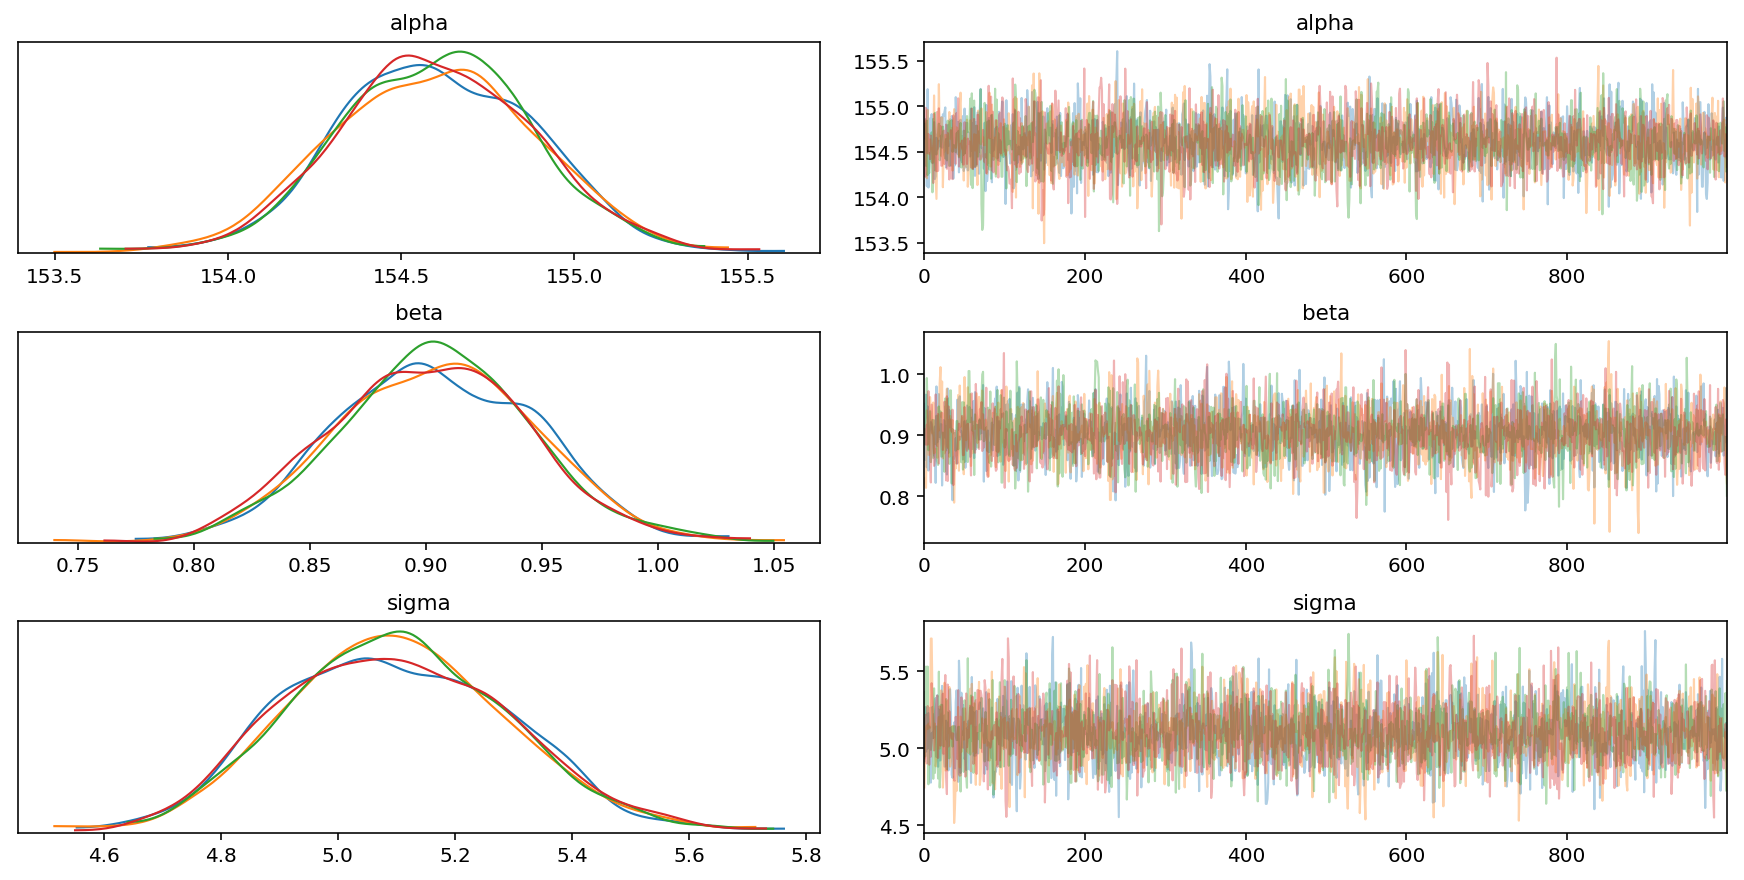

In [151]:
az.plot_trace(trace_m1_v2, var_names="~mu")
#pm.traceplot(trace_m1_v2) # the same
pass

##### Check posterior prediction

In [188]:
d2 = d2.assign(height_hat = np.mean(posterior_pred_v2["height_hat"], axis=0))

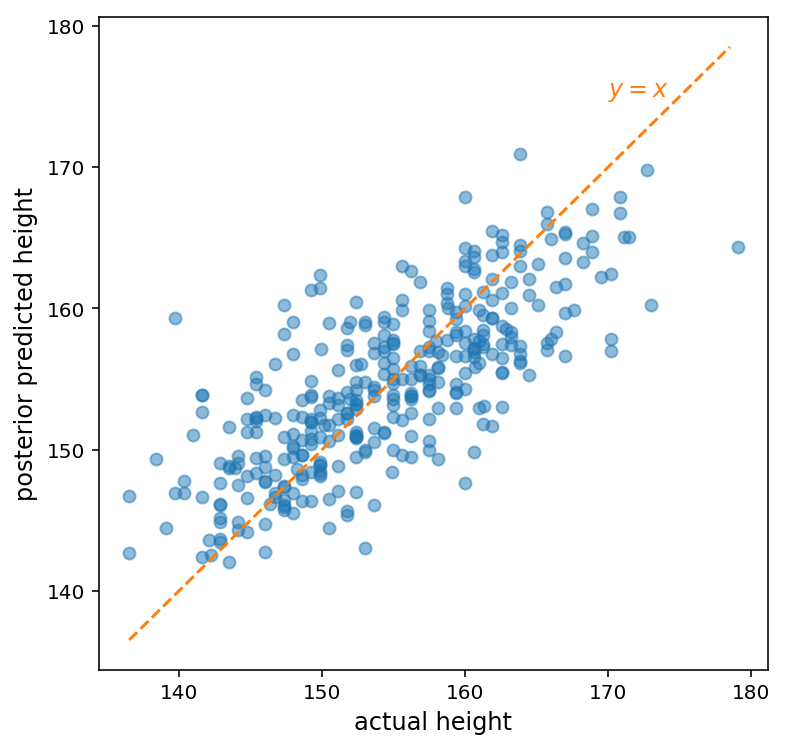

In [223]:
plt.figure(figsize=(6,6))
plt.scatter(d2.height, d2.height_hat, alpha=0.5)
plt.plot(np.arange(d2.height.min(), d2.height.max()), 
         np.arange(d2.height.min(), d2.height.max()), 
         'C1--')
plt.text(170, 175, r"$y=x$", fontsize=12, color='C1')
plt.xlabel("actual height")
plt.ylabel("posterior predicted height")
plt.xticks(np.arange(140, 181, 10))
plt.yticks(np.arange(140, 181, 10))
pass

In [228]:
print(f"RMSE in train set is {round(np.sqrt(mean_squared_error(d2.height, d2.height_hat)),2)}cm")

RMSE in train set is 5.07cm


##### Make prediction for new data points

In [235]:
with m1_v2:
    pm.set_data({"weight_c": d_q1.weight - d2.weight.mean()})
    height_ppc = pm.sample_posterior_predictive(trace_m1_v2, samples=1000)

/Applications/anaconda3/envs/stats/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1000/1000 [00:09<00:00, 103.73it/s]


In [240]:
d_q1

,individual,weight,sim_height,expected_height,hpd_interval
0,1,45,"[156.44376017388694, 160.8098251876811, 150.06...",154.5,"[146.2, 162.7]"
1,2,40,"[151.99988733023434, 156.31473114371377, 145.8...",150.0,"[141.7, 158.2]"
2,3,65,"[174.21925154849725, 178.7902013635505, 166.81...",172.6,"[164.3, 180.9]"
3,4,31,"[144.0009162116597, 148.22356186457253, 138.35...",141.9,"[133.8, 150.4]"
4,5,53,"[163.55395672373106, 168.00197565802884, 156.7...",161.8,"[154.2, 170.7]"


In [260]:
d_q1["expected_height_v2"] = height_ppc['height_hat'].mean(axis=0)
d_q1["hpd_v2"] = pd.Series(list(np.round(az.hpd(height_ppc['height_hat']),2)))

In [261]:
d_q1.drop("sim_height", axis=1)

,individual,weight,expected_height,hpd_interval,expected_height_v2,hpd_v2
0,1,45,154.5,"[146.2, 162.7]",154.555850,"[147.13, 162.19]"
1,2,40,150.0,"[141.7, 158.2]",149.827851,"[141.13, 157.61]"
2,3,65,172.6,"[164.3, 180.9]",172.746663,"[164.99, 181.07]"
3,4,31,141.9,"[133.8, 150.4]",142.180463,"[135.11, 150.26]"
4,5,53,161.8,"[154.2, 170.7]",161.772906,"[154.61, 169.85]"


#### Q2.v1
Model the relationship between height (cm) and the natural logarithm of weight (log-kg): log(weight). Use the entire Howell1 data frame, all 544 rows, adults and non-adults. Use any model type from Chapter 4 (from the book) that you think useful: an ordinary linear regression, a polynomial or a spline. Plot the posterior predictions against the raw data.

##### Data transformation and basic relationship check

In [266]:
d['log_weight'] = np.log(d['weight'])

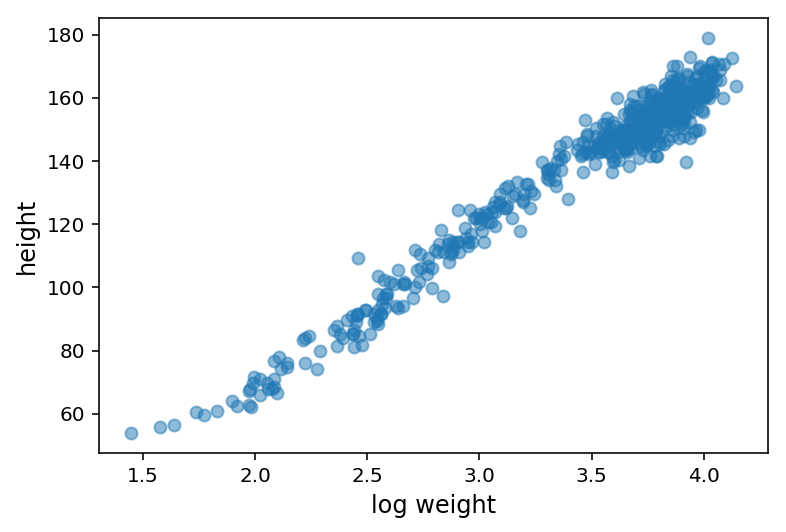

In [271]:
plt.figure(figsize=(6,4))
plt.scatter(d.log_weight, d.height, alpha=0.5)
plt.xlabel("log weight")
plt.ylabel("height")
pass

In [276]:
print(f"Pearson correlation score between log_weight and height is {stats.pearsonr(d.log_weight, d.height)[0]:.2f}")

Pearson correlation score between log_weight and height is 0.98


Based on the scatter plot and pearson correlation score, linear regression without polynomial terms should fit the data reasonably well. For some extra fun, lets do a degree=1 linear regression as well as a B-Spline regression. 

##### No-poly regression

In [280]:
with pm.Model() as m2:
    # Data
    log_weight = pm.Data("log_weight", d.log_weight - d.log_weight.mean())
    height = pm.Data("height", d.height)
    
    # Priors
    alpha = pm.Normal("alpha", mu=178, sigma=20)
    beta = pm.Lognormal("beta", mu=0, sigma=1)
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    
    # Regrssion - Deterministic variable under prior
    mu = pm.Deterministic("mu", alpha + beta * log_weight)
    
    # Regression - Likelihood
    height_hat = pm.Normal("height_hat", mu=mu, sigma=sigma, observed=height)
    
    # Sampling
    np.random.seed(153)
    trace_m2 = pm.sample(draws=1000, tune=1000)
    prior_pred_m2 = pm.sample_prior_predictive(samples=1000)
    posterior_pred_m2 = pm.sample_posterior_predictive(trace_m2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]
100%|██████████| 4000/4000 [00:35<00:00, 111.29it/s]


##### Check posterior

Alpha is still the expected height when $weight_{i} = mean(weight)$.  But after log transform, it is harder to interpret beta directly.

In [281]:
az.summary(trace_m2, var_names="~mu", kind="stats")

,mean,sd,hpd_5.5%,hpd_94.5%
alpha,138.271,0.227,137.884,138.611
beta,47.077,0.385,46.458,47.672
sigma,5.157,0.161,4.906,5.411


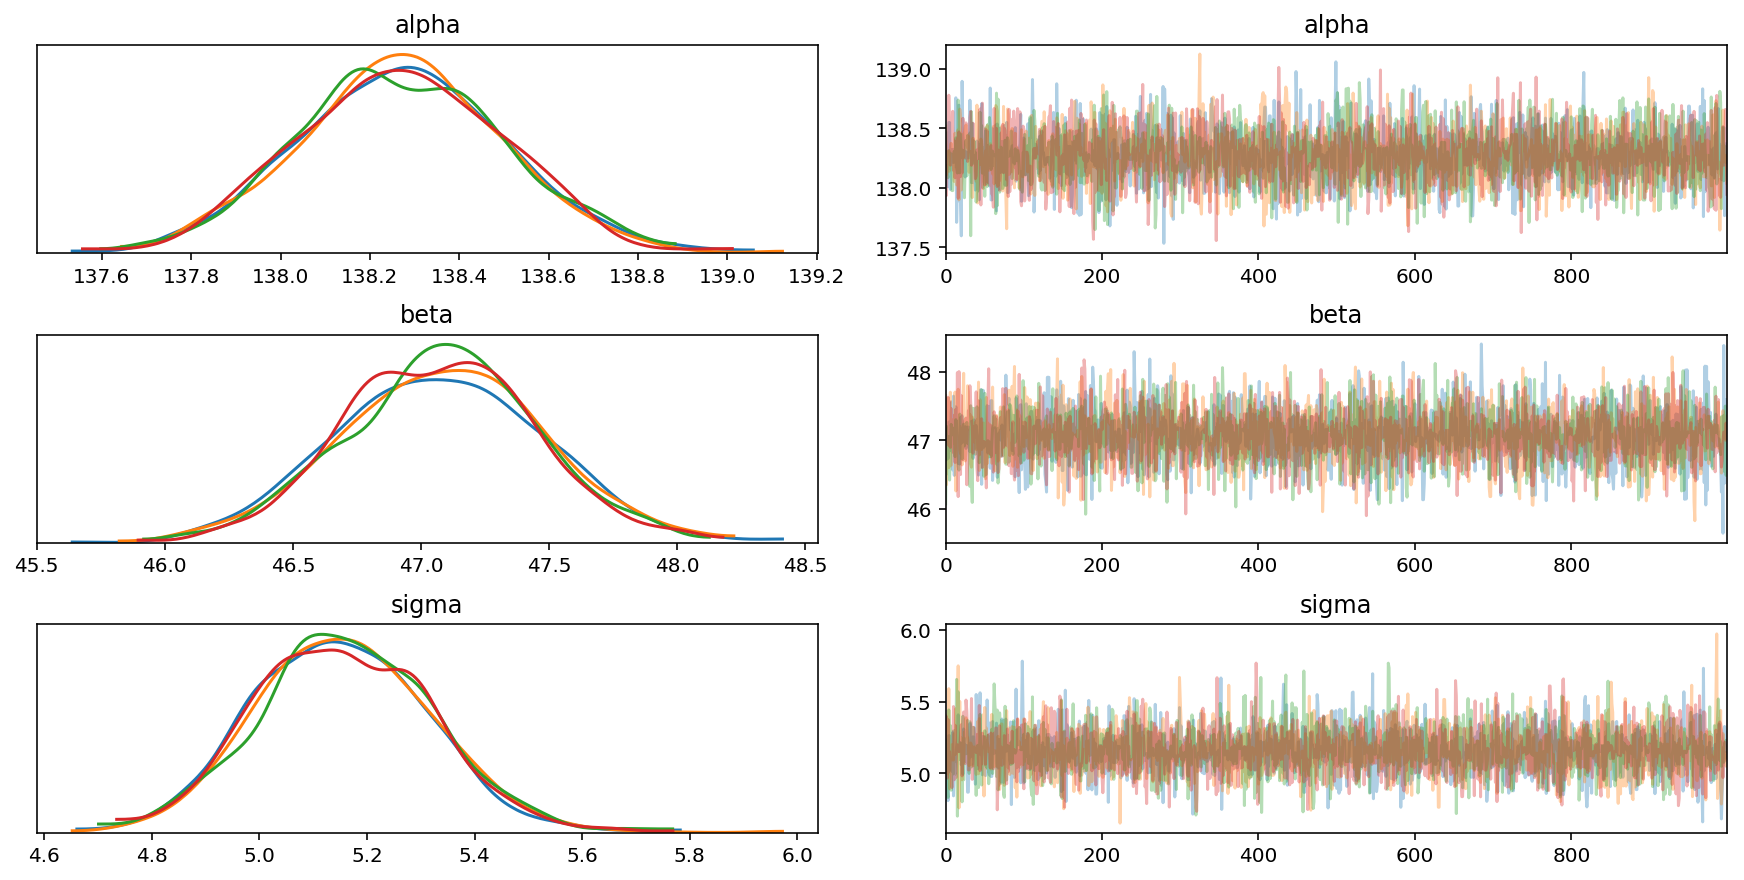

In [284]:
pm.plot_trace(trace_m2, var_names='~mu')
pass

##### Check posterior predictive

1. plot predicted again true values

In [285]:
d = d.assign(height_hat = np.mean(posterior_pred_m2["height_hat"], axis=0))

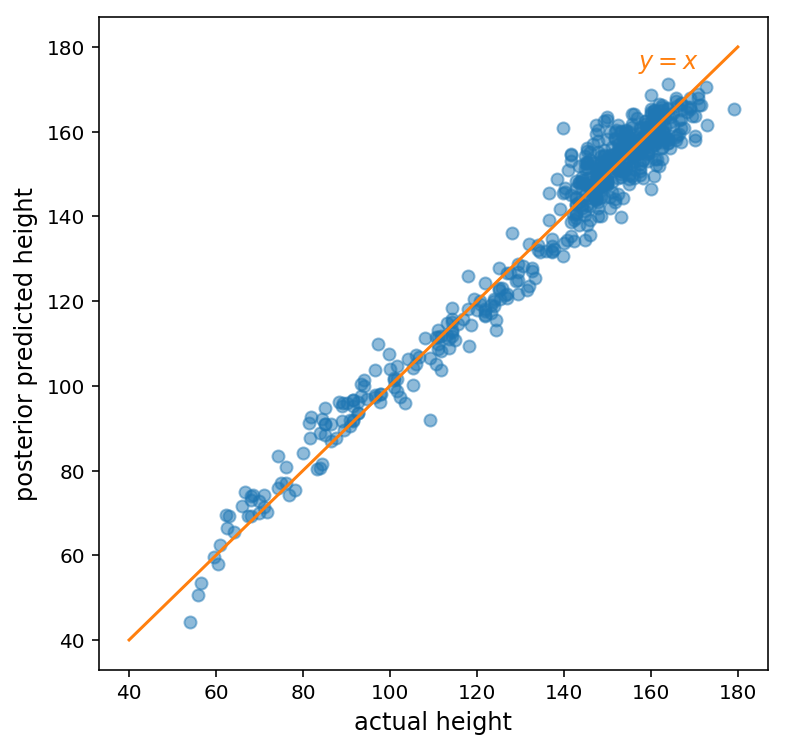

In [291]:
plt.figure(figsize=(6,6))
plt.scatter(d.height, d.height_hat, alpha=0.5)
plt.plot([40, 180], [40, 180], 'C1-', linewidth=1.5)
plt.text(157, 175, r"$y=x$", fontsize=12, color='C1')
plt.xlabel("actual height")
plt.ylabel("posterior predicted height")
plt.xticks(np.arange(40, 181, 20))
plt.yticks(np.arange(40, 181, 20))
pass

2. get RMSE

In [292]:
print(f"RMSE in train set is {round(np.sqrt(mean_squared_error(d.height, d.height_hat)),2)}cm")

RMSE in train set is 5.14cm


3. plot prediction intervals

In [296]:
d.weight.min(), d.weight.max()

(4.252425, 62.992589)

In [360]:
weight_seq=np.arange(1, 66)
weight_log = np.log(weight_seq)
mu_pred = (trace_m2['alpha'] + trace_m2["beta"] * (weight_log - d.log_weight.mean()).reshape(-1, 1)).T
mu_hpd = az.hpd(mu_pred)

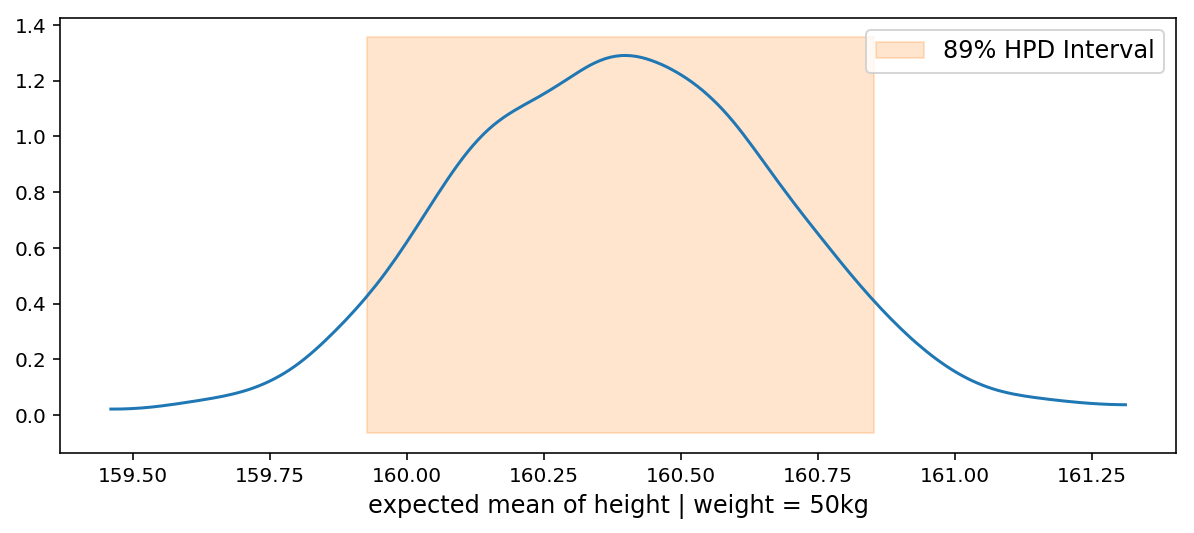

In [340]:
# kde when weight = 50 kg
id_50 = np.argwhere(weight_log==np.log(50))[0,0]
pm.kdeplot(mu_pred[:, id_50])
plt.fill_betweenx(y=plt.ylim(), x1=mu_hpd[id_50, 0], x2=mu_hpd[id_50, 1], color='C1', alpha=0.2, label="89% HPD Interval")
plt.legend()
plt.xlabel('expected mean of height | weight = 50kg')
pass

The 89% HPD interval's range is smaller than 1cm, when weight = 50kg. Not bad at all. Lets plot for all weights and see how the model performs overall.

In [347]:
with m2:
    pm.set_data({"log_weight": weight_log - d.log_weight.mean()})
    posterior_pred_m2_ext = pm.sample_posterior_predictive(trace_m2, 1000*trace_m2.nchains)

100%|██████████| 4000/4000 [00:40<00:00, 97.93it/s] 


In [348]:
height_hat_m2 = posterior_pred_m2_ext["height_hat"]

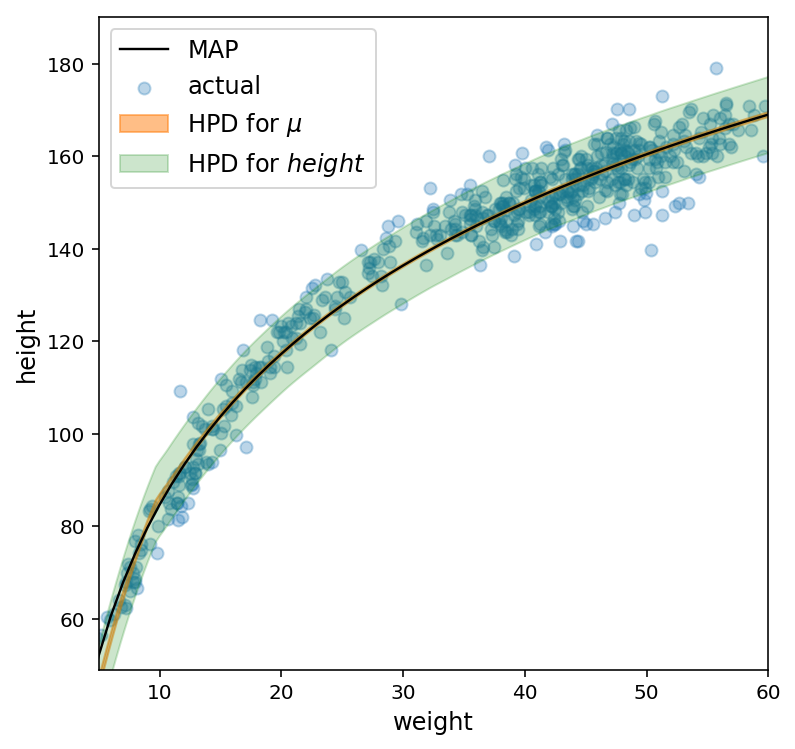

In [388]:
plt.figure(figsize=(6,6))
plt.scatter(d.weight, d.height, alpha=0.3, label='actual')
plt.plot(weight_seq, mu_pred.mean(axis=0), 'k', linewidth=1.2, label='MAP')
az.plot_hpd(weight_seq, mu_pred, color='C1',
           fill_kwargs={"alpha":0.5, "label":r"HPD for $\mu$"})
az.plot_hpd(weight_seq, height_hat_m2, color='g',
           fill_kwargs={"alpha":0.2, "label":r"HPD for $height$"})
plt.xlim(5, 60)
plt.ylim(49, 190)
plt.xlabel('weight')
plt.ylabel('height')
plt.legend()
pass

When weight is low and there are fewer data points, MAP of $\mu$ is outside the 89% HPD. Interesting .... let me double check.

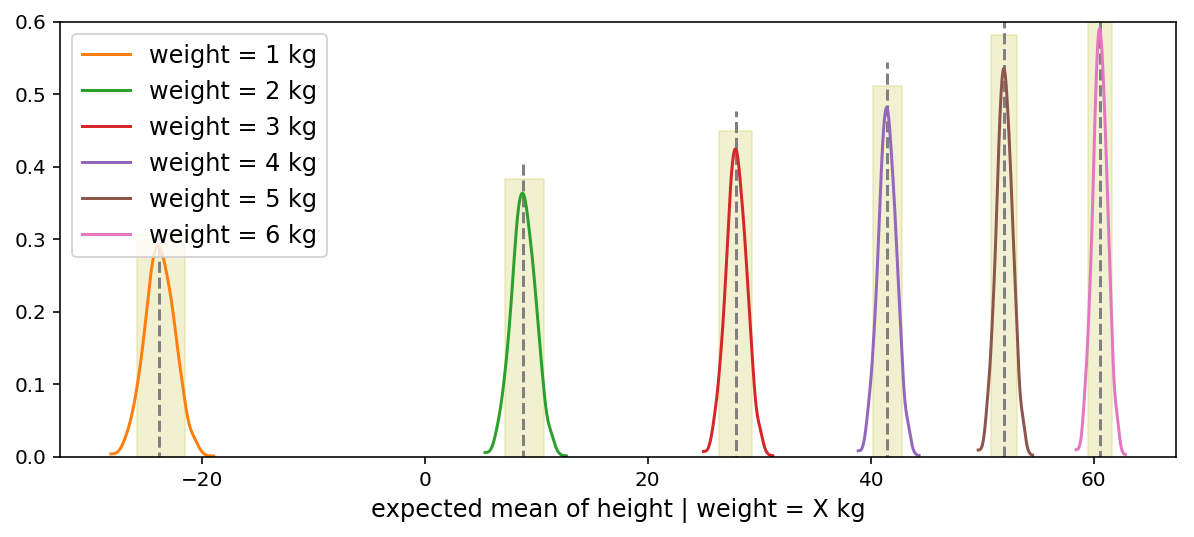

In [379]:
# kde when weight = 1-6 kg
for w in range(1, 7):
    row_id = np.argwhere(weight_log==np.log(w))[0,0]
    pm.kdeplot(mu_pred[:, row_id], label=f"weight = {w} kg", plot_kwargs={"color":f"C{w}"})
    plt.fill_betweenx(y=plt.ylim(), x1=mu_hpd[row_id, 0], x2=mu_hpd[row_id, 1], color='C8', alpha=0.2)
    plt.vlines(mu_pred[:, row_id].mean(), *plt.ylim(), color='grey', linestyle='--')
plt.legend()
plt.ylim(0, 0.6)
plt.xlabel('expected mean of height | weight = X kg')
pass

So when weight = 1kg, the model actually has the expectation of a negative height. That's pretty bad. I doubt that a B-Spline model can fix it, since it is quite geocentric as well.  

This new observation still doesn't answer why in posterior interval plot, the MAP is outside the HPD. Because in the plot above, the mean of $\mu$ IS in HPD. So weird. Sth I did wrong or is it just a plotting glitch?

#### Q3.v1
Plot the prior predictive distribution for the polynomial regression model
in Chapter 4. You can modify the the code that plots the linear regression
prior predictive distribution. 20 or 30 parabolas from the prior should suffice to show where the prior probability resides. Can you modify the prior
distributions of α, β1, and β2 so that the prior predictions stay within the
biologically reasonable outcome space? That is to say: Do not try to fit the
data by hand. But do try to keep the curves consistent with what you know
about height and weight, before seeing these exact data.

In [390]:
d.head()

,height,weight,age,male,log_weight,height_hat
0,151.765,47.825606,63.0,1,3.867561,158.310428
1,139.700,36.485807,63.0,0,3.596923,145.574898
2,136.525,31.864838,65.0,0,3.461503,139.071077
3,156.845,53.041915,41.0,1,3.971082,163.164591
4,145.415,41.276872,51.0,0,3.720302,151.333954


In [521]:
d = (pd.read_csv("~/Learning_DS/pymc3_resources/Rethinking_2/Data/Howell1.csv", sep=";", header=0)
     .assign(
        weight_std = (d.weight - d.weight.mean())/d.weight.std(),
        weight_std2 = lambda df: df.weight_std**2)
    )

with pm.Model() as m3:
    # data
    height = pm.Data("height", d.height)
    weight1 = pm.Data("weight1", d.weight_std)
    weight2 = pm.Data("weight2", d.weight_std2)
    
    # prior
    a = pm.Normal("a", mu=178, sigma=20)
    b1 = pm.Lognormal("b1", mu=0, sigma=1)
    b2 = pm.Normal("b2", mu=0, sigma=1)
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    
    # regression
    mu = pm.Deterministic("mu", a + b1 * weight1 + b2 * weight2)
    height_hat = pm.Normal("height_hat", mu=mu, sigma=sigma, observed=height)
    
    # sampling
    np.random.seed(125)
    trace_m3 = pm.sample(1000, tune=1000)
    prior_pred_m3 = pm.sample_prior_predictive(samples=100)
    posterior_pred_m3 = pm.sample_posterior_predictive(trace_m3, samples=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b2, b1, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:03<00:00, 2442.99draws/s]
/Applications/anaconda3/envs/stats/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1000/1000 [00:09<00:00, 101.05it/s]


##### plot prior predictive

In [449]:
weight_seq = np.arange(1, 66)
weight_seq_std = (weight_seq - d.weight.mean()) / d.weight.std()
mu_pred = (prior_pred_m3['a'] + prior_pred_m3['b1'] * (weight_seq_std).reshape(-1, 1) + prior_pred_m3['b1'] * (weight_seq_std**2).reshape(-1, 1)).T
mu_hpd = pm.hpd(mu_pred)

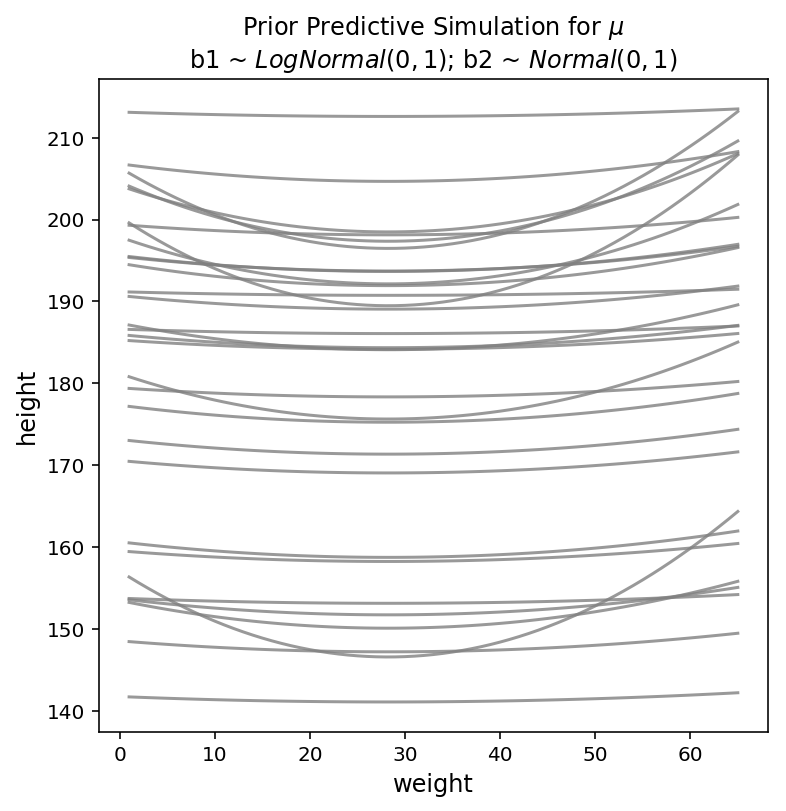

In [470]:
plt.figure(figsize=(6,6))
for idx in range(mu_pred.shape[0])[:30]:
    plt.plot(weight_seq, mu_pred[idx], 'grey', alpha=0.8)
plt.xlabel("weight")
plt.ylabel("height")
plt.title('Prior Predictive Simulation for $\mu$ \nb1 ~ $LogNormal(0,1)$; b2 ~ $Normal(0,1)$')
pass

I know that I want the parabola to bend downwards like a hat and the openning to face the bottom right area. This setup meets the expectation that a person cannot just keep growing taller but he can get heavier once he reaches his adult maximum height. In math, when beta2 is negative, the parabola bends downwards. Is it possible to control the openning to face bottom right ? I dont know... Lets draw a couple parabolas to understand what my prior parameters could be.

##### Change only beta2

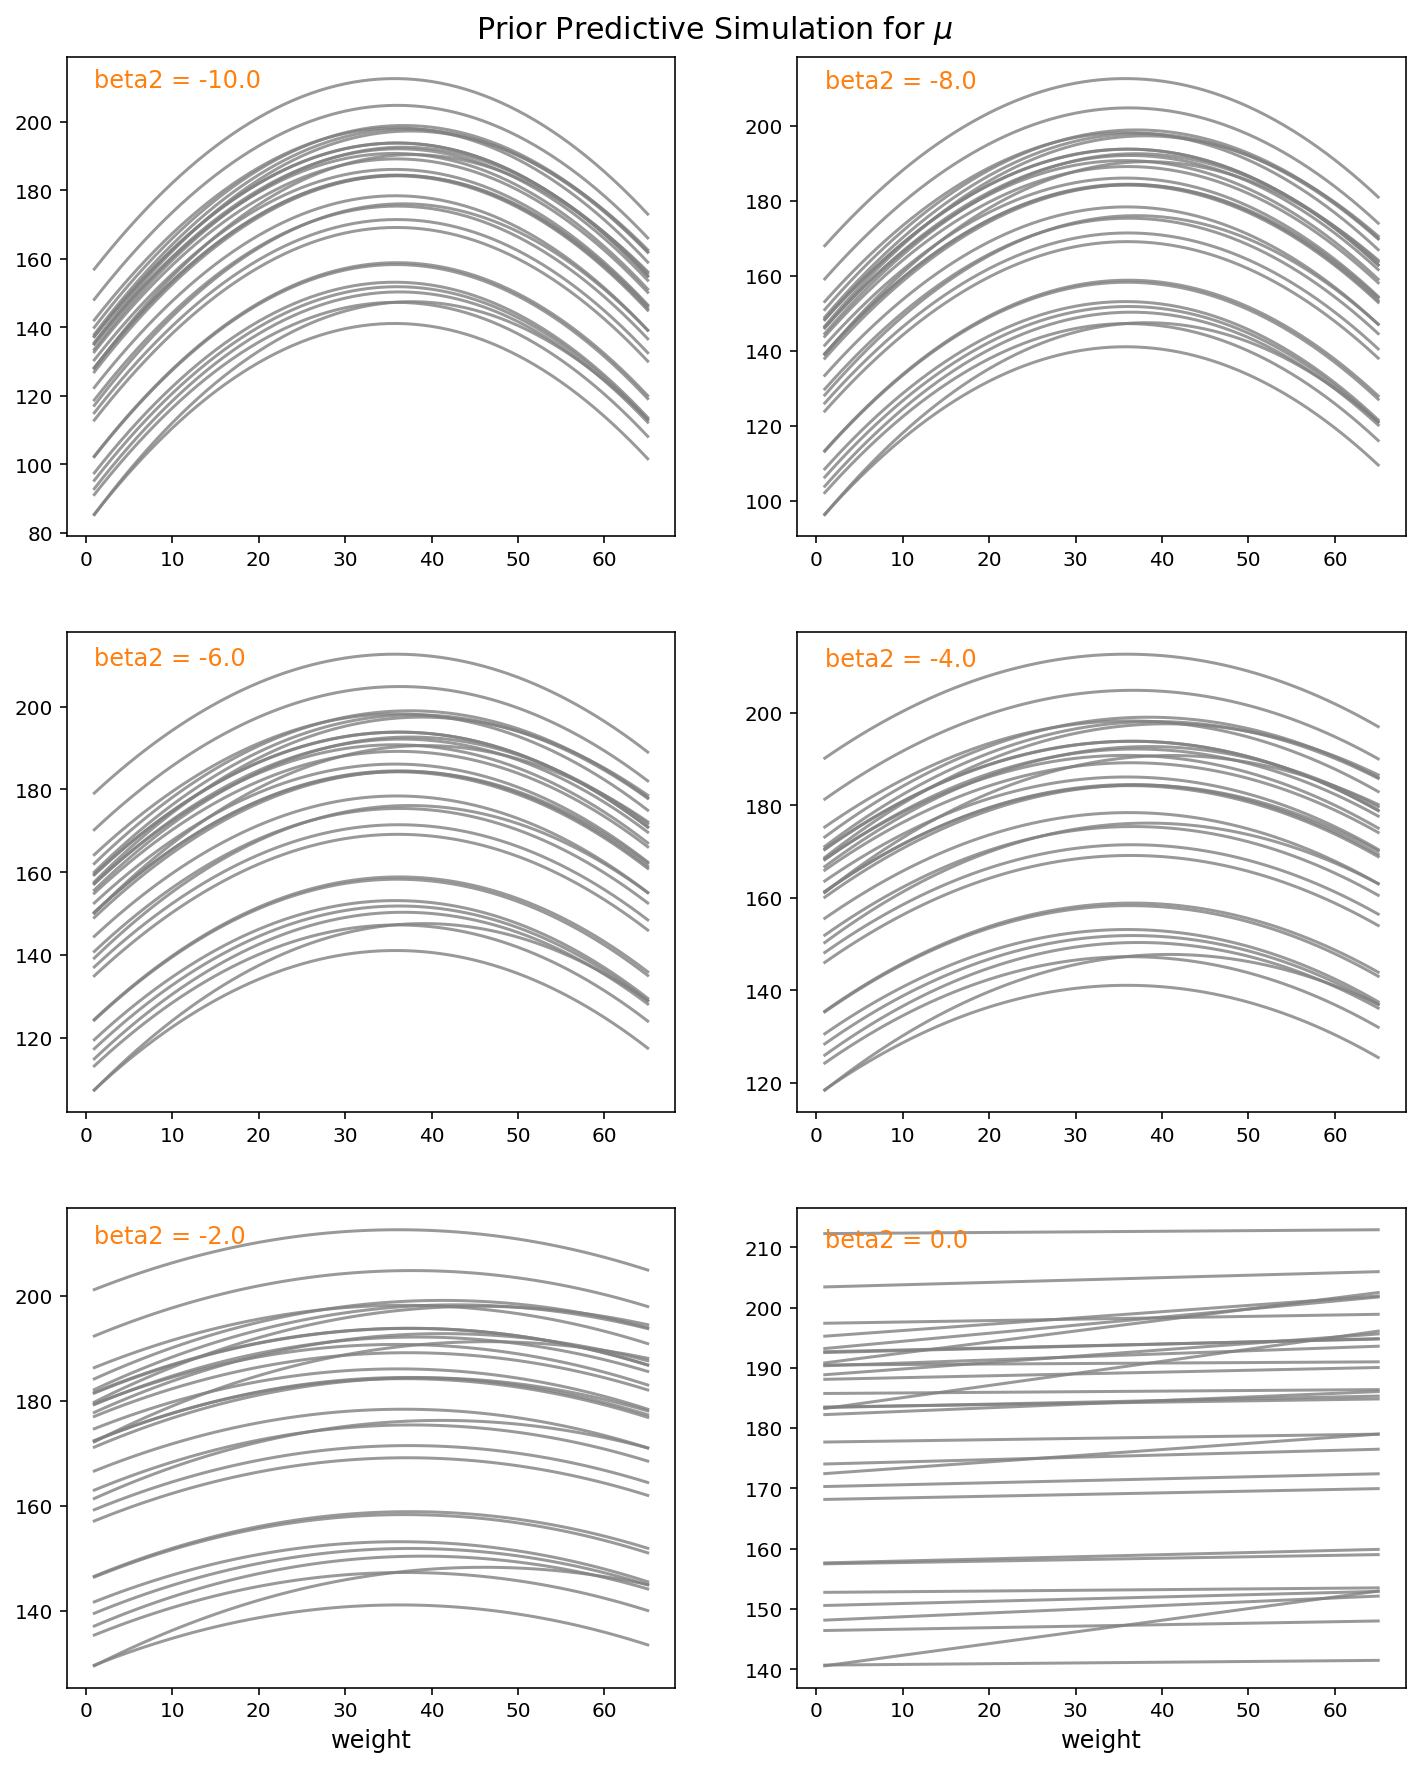

In [498]:
beta2_range = np.linspace(-10, 0, num=6)

_, axes = plt.subplots(nrows=int(len(beta2_range)/2), ncols=2, figsize=(12,15))
axes = axes.ravel()

for b_idx, beta2 in enumerate(beta2_range):
    mu_pred = (prior_pred_m3['a'] + prior_pred_m3['b1'] * (weight_seq_std).reshape(-1, 1) + beta2 * (weight_seq_std**2).reshape(-1, 1)).T

    axes[b_idx].text(x=1, y=210, s=f"beta2 = {beta2:.1f}", color='C1', fontsize=12)
    
    for idx in range(mu_pred.shape[0])[:30]:
        axes[b_idx].plot(weight_seq, mu_pred[idx], 'grey', alpha=0.8)    
        
axes[-1].set_xlabel("weight")
axes[-2].set_xlabel("weight")
plt.suptitle('Prior Predictive Simulation for $\mu$', x=0.5, y=0.9)
pass

So now those with avg weight will be the tallest. It kind of makes sense. If someone is really heavy early on in life, it may affect his growth in height. Now I need to see how to control the openning to face bottom right. 

##### Change only beta1 while keeping beta2 = -2

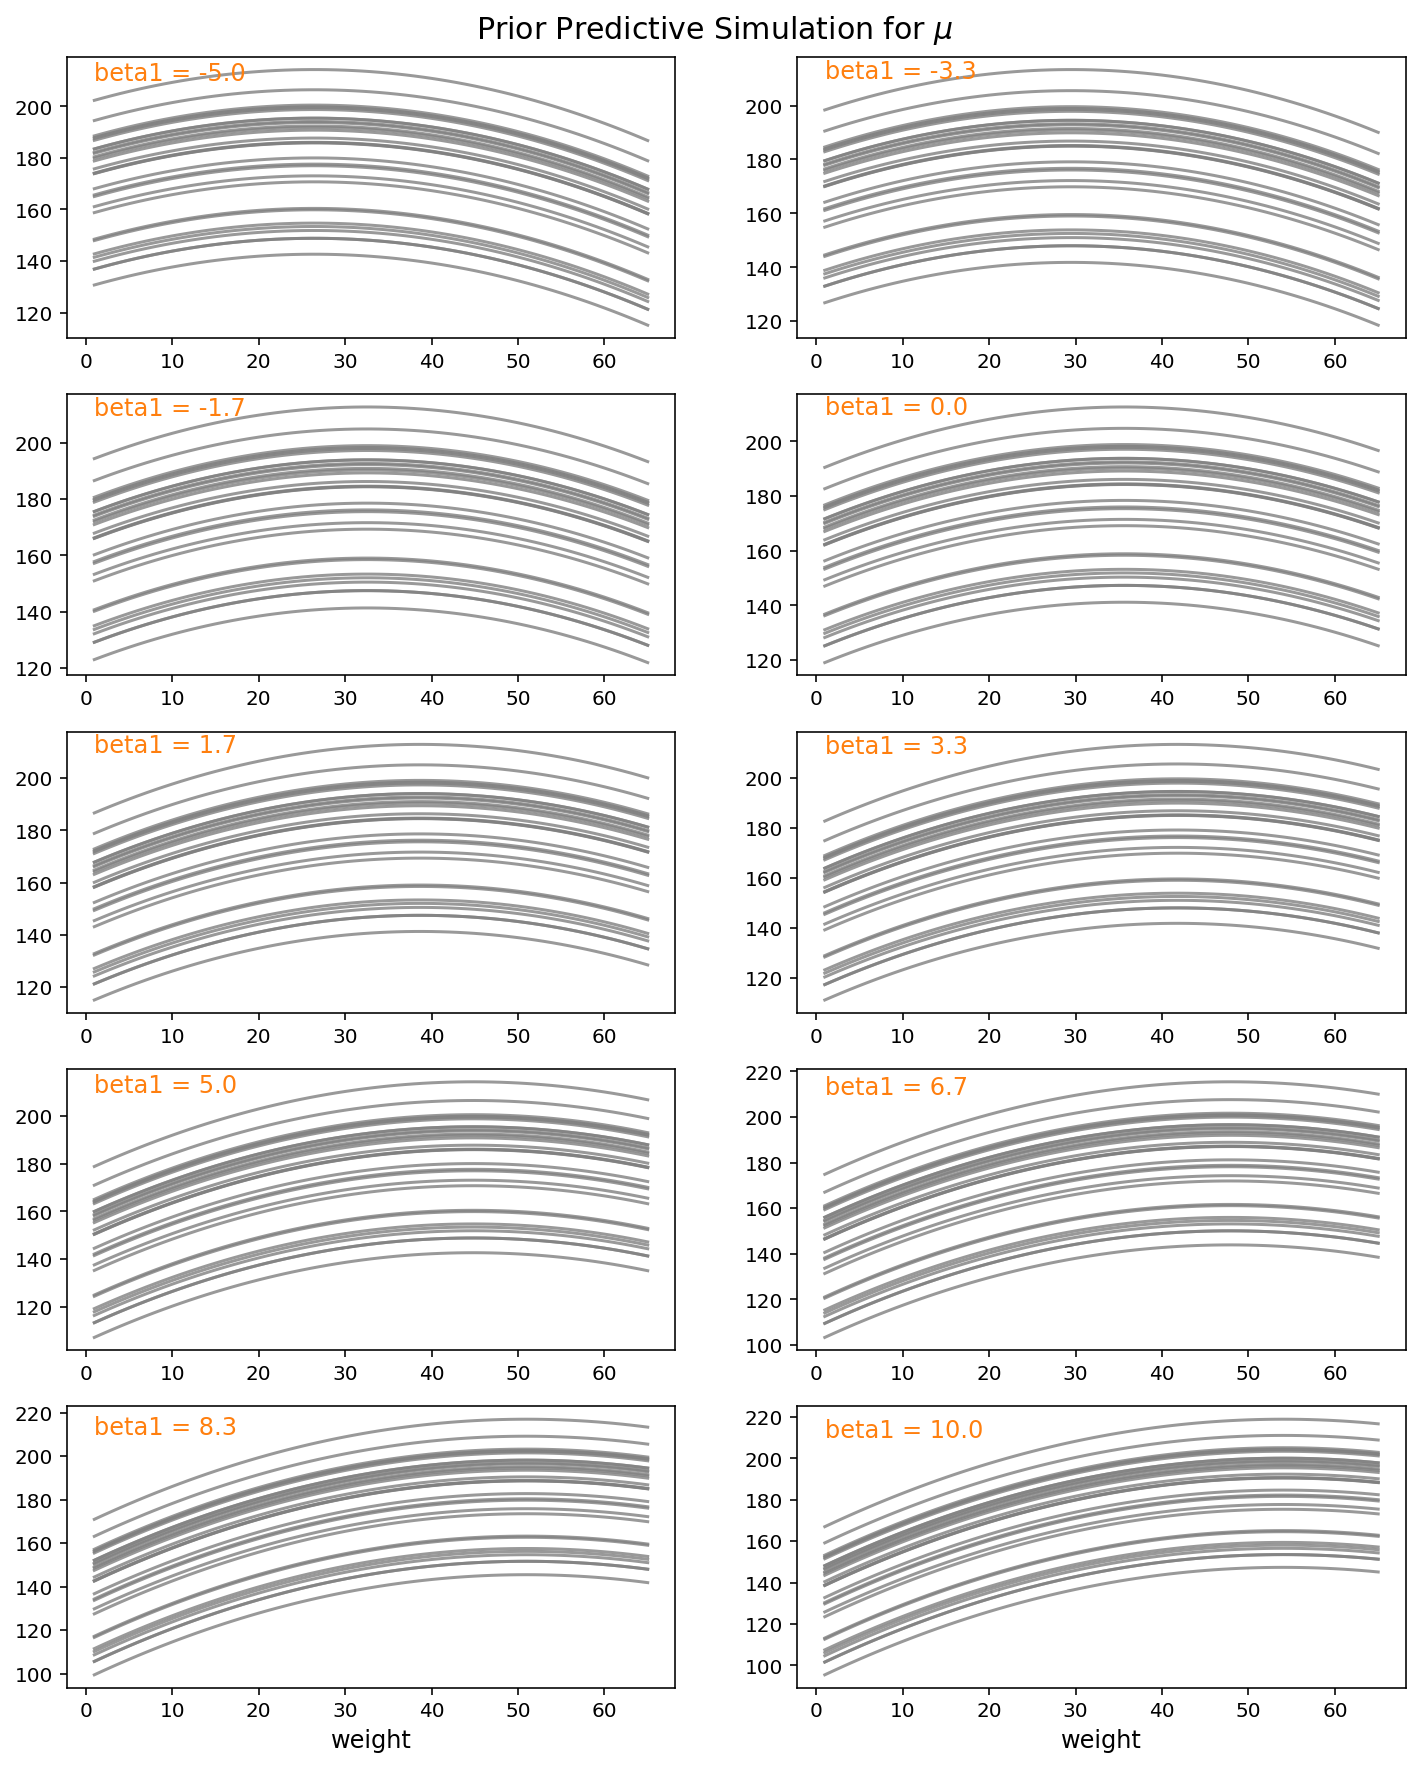

In [506]:
beta1_range = np.linspace(-5, 10, num=10)

_, axes = plt.subplots(nrows=int(len(beta1_range)/2), ncols=2, figsize=(12,15))
axes = axes.ravel()

for b_idx, beta1 in enumerate(beta1_range):
    mu_pred = (prior_pred_m3['a'] + beta1 * (weight_seq_std).reshape(-1, 1) + -4 * (weight_seq_std**2).reshape(-1, 1)).T

    axes[b_idx].text(x=1, y=210, s=f"beta1 = {beta1:.1f}", color='C1', fontsize=12)
    
    for idx in range(mu_pred.shape[0])[:30]:
        axes[b_idx].plot(weight_seq, mu_pred[idx], 'grey', alpha=0.8)    
        
axes[-1].set_xlabel("weight")
axes[-2].set_xlabel("weight")
plt.suptitle('Prior Predictive Simulation for $\mu$', x=0.5, y=0.9)
pass

Ok. So I need a positve beta1 and a negative beta2. beta1 >=2 and beta2 <= -2 seems reasonable. Let me plot several lognormal pdfs to understand how u and sigma alter the distribution. Conclusion: set beta1 ~ lognormal(1.5, 1) and beta2 ~ **-** lognormal(1.5, 1).

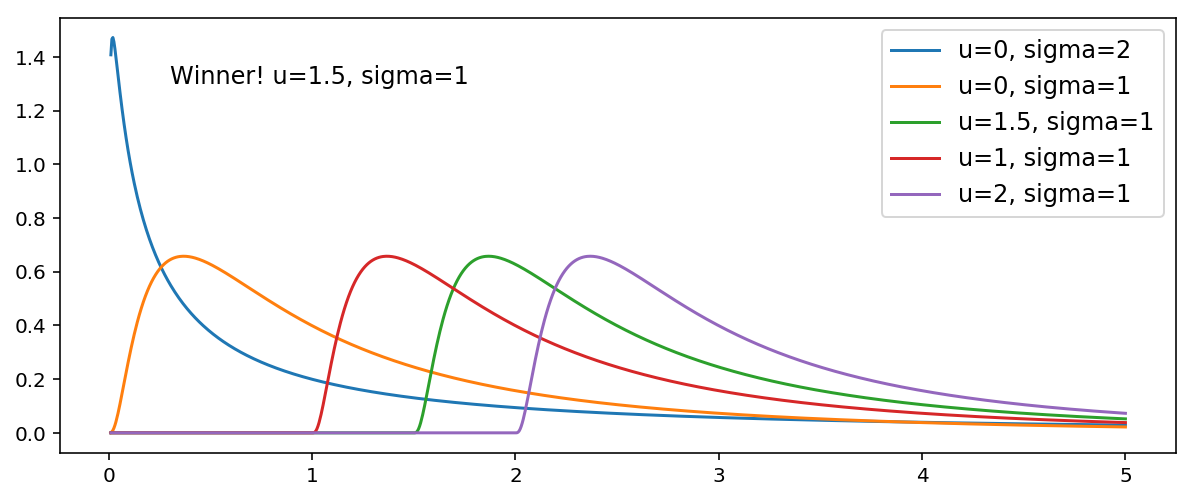

In [516]:
x_lnorm = np.linspace(0.01, 5, num=1000)
for loc, scale in [(0, 2), (0, 1), (1.5, 1), (1, 1), (2, 1)]:
    plt.plot(x_lnorm, stats.lognorm.pdf(x_lnorm, loc=loc, s=scale), label= f"u={loc}, sigma={scale}")
plt.legend()
plt.text(x=0.3, y=1.3, s="Winner! u=1.5, sigma=1", fontsize=12, color='k')
pass

In [522]:
with pm.Model() as m3_new:
    # data
    height = pm.Data("height", d.height)
    weight1 = pm.Data("weight1", d.weight_std)
    weight2 = pm.Data("weight2", d.weight_std2)
    
    # prior
    a = pm.Normal("a", mu=178, sigma=20)
    b1 = pm.Lognormal("b1", mu=1.5, sigma=1)
    b2 = - pm.Lognormal("b2", mu=1.5, sigma=1)
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    
    # regression
    mu = pm.Deterministic("mu", a + b1 * weight1 + b2 * weight2)
    height_hat = pm.Normal("height_hat", mu=mu, sigma=sigma, observed=height)
    
    # sampling
    np.random.seed(125)
    trace_m3_new = pm.sample(1000, tune=1000)
    prior_pred_m3_new = pm.sample_prior_predictive(samples=100)
    posterior_pred_m3_new = pm.sample_posterior_predictive(trace_m3_new, samples=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b2, b1, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:02<00:00, 2788.07draws/s]
/Applications/anaconda3/envs/stats/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1000/1000 [00:09<00:00, 100.27it/s]


##### Compare two models

In [525]:
d = (d.assign(
    height_hat = posterior_pred_m3["height_hat"].mean(axis=0),
    height_hat_new = posterior_pred_m3_new["height_hat"].mean(axis=0)
))

print(f"RMSE in train set for old prior is {round(np.sqrt(mean_squared_error(d.height, d.height_hat)),2)}cm")
print(f"RMSE in train set for new prior is {round(np.sqrt(mean_squared_error(d.height, d.height_hat_new)),2)}cm")

RMSE in train set for old prior is 5.78cm
RMSE in train set for new prior is 5.75cm


In [527]:
az.summary(trace_m3, var_names="~mu")

,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,146.046,0.380,145.428,146.634,0.008,0.006,2086.0,2086.0,2085.0,2143.0,1.0
b2,-7.789,0.282,-8.242,-7.343,0.006,0.004,2018.0,2006.0,2016.0,2128.0,1.0
b1,21.742,0.296,21.268,22.214,0.006,0.004,2193.0,2190.0,2181.0,2755.0,1.0
sigma,5.811,0.185,5.500,6.083,0.003,0.002,3102.0,3099.0,3100.0,2855.0,1.0


In [528]:
az.summary(trace_m3_new, var_names="~mu")

,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,146.658,0.373,146.047,147.245,0.008,0.005,2361.0,2361.0,2357.0,2517.0,1.0
b1,21.414,0.291,20.959,21.880,0.005,0.004,2841.0,2841.0,2849.0,2877.0,1.0
b2,8.407,0.280,7.948,8.831,0.006,0.004,2261.0,2261.0,2255.0,2433.0,1.0
sigma,5.780,0.179,5.495,6.052,0.003,0.002,2688.0,2673.0,2725.0,2585.0,1.0


I set b2 = - lognormal in new model, so b2 in the new model has almost the same values as b2 in old model. The same goes for all parameters. The additional prior adjustment has little gains in this dataset. According to the auther, it is because of the large sample size (544). 